Prompt "Drum loop of..." → Base Model (MusicGen-Large / MusicGen-Small) → Drum loop audio in .wav → Convert to MIDI (OaF-Drums)

In [1]:
import subprocess
import os
import requests
import io
import scipy
import soundfile as sf
from pydub import AudioSegment
from IPython.display import Audio, display
import ipywidgets as widgets
import librosa
import librosa.display
import matplotlib.pyplot as plt

#Initialize OaF Model
import tensorflow.compat.v1 as tf
import librosa
import numpy as np

from magenta.common import tf_utils
from note_seq import audio_io
from magenta.models.onsets_frames_transcription import audio_label_data_utils
from magenta.models.onsets_frames_transcription import configs
from magenta.models.onsets_frames_transcription import constants
from magenta.models.onsets_frames_transcription import data
from magenta.models.onsets_frames_transcription import infer_util
from magenta.models.onsets_frames_transcription import train_util
import note_seq
from note_seq import midi_io
from note_seq import sequences_lib

tf.disable_v2_behavior()

## Define model and load checkpoint
## Only needs to be run once.

EGMD_CHECKPOINT_DIR="e-gmd"

config = configs.CONFIG_MAP['drums']
hparams = config.hparams
hparams.batch_size = 1
checkpoint_dir = EGMD_CHECKPOINT_DIR

examples = tf.placeholder(tf.string, [None])

dataset = data.provide_batch(
    examples=examples,
    preprocess_examples=True,
    params=hparams,
    is_training=False,
    shuffle_examples=False,
    skip_n_initial_records=0)

estimator = train_util.create_estimator(
    config.model_fn, checkpoint_dir, hparams)

iterator = tf.data.make_initializable_iterator(dataset)
next_record = iterator.get_next()

C:\Users\ayrmo\miniconda3\envs\magentapy3.7\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
C:\Users\ayrmo\miniconda3\envs\magentapy3.7\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


Instructions for updating:
non-resource variables are not supported in the long term
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(dataset)`.

INFO:tensorflow:Using config: {'_model_dir': 'e-gmd', '_tf_random_seed': None, '_save_summary_steps': 300, '_save_checkpoints_steps': 300, '_save_checkpoints_secs

In [2]:
import requests
from IPython.display import Audio, display
import ipywidgets as widgets

# Define API details
HF_TOKEN = "YOUR-HF-TOKEN-HERE"
API_URL_SMALL = "https://api-inference.huggingface.co/models/facebook/musicgen-small"

# For running MUSICGEN-LARGE, you need to add your Endpoint API URL
# API_URL_LARGE = "add-your-enpoind-api-url-here"

headers = {
    "Accept": "application/json",
    "Authorization": "Bearer " + HF_TOKEN,
    "Content-Type": "application/json"
}

# Function to query the API
def query(payload, api_url):
    response = requests.post(api_url, headers=headers, json=payload)
    if api_url == API_URL_SMALL:
        return response.content  # Use content for musicgen-small
    else:
        return response.json()  # Use JSON for musicgen-large

# Create dropdown for model selection
model_dropdown = widgets.Dropdown(
    options=[('musicgen-small (inference API serverless)', API_URL_SMALL),
             ('musicgen-large (inference endpoint)', API_URL_LARGE)],
    value=API_URL_SMALL,
    description='Model:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='350px')  # Adjust width
)

# Text area for prompt input
prompt_input = widgets.Textarea(
    value='',
    placeholder='Describe what music you want to create...',
    description='Prompt:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='500px', height='100px', resize='both')  # Adjust width
)

# Button to trigger query
generate_button = widgets.Button(
    description="Generate Music",
    button_style='primary',
    tooltip='Click to generate music based on the prompt',
    icon='music',
    layout=widgets.Layout()  # Adjust button size
)

# Output widget for displaying audio
output_widget = widgets.Output()

# Define global variables
audio_wav = None
sampling_rate = None

# Event handler for button click
def on_generate_click(b):
    global audio_wav, sampling_rate  # Ensure these are global
    with output_widget:
        output_widget.clear_output()
        api_url = model_dropdown.value
        prompt = prompt_input.value
        if not prompt:
            print("Please enter a prompt.")
            return

        print(f"Using model: {model_dropdown.label}")
        data = {"inputs": prompt}
        output = query(data, api_url)
        
        if api_url == API_URL_SMALL:
            # Handle output for musicgen-small
            audio = AudioSegment.from_file(io.BytesIO(output), format="flac")
            sampling_rate = audio.frame_rate
            print("Sampling Rate: ", sampling_rate)
            
            # Create WAV data in memory
            wav_buffer = io.BytesIO()
            audio.export(wav_buffer, format="wav", parameters=["-acodec", "pcm_s16le"])
            audio_wav = wav_buffer.getvalue()
            
            # Play the generated audio
            print("Playing generated audio...")
            display(Audio(output, rate=sampling_rate))
            
        elif api_url == API_URL_LARGE:
            # Handle output for musicgen-large
            sampling_rate = output[0]["sampling_rate"]
            audio_values = output[0]["audio_values"]
            
            # Scale audio to int16 range
            audio_scaled = (np.squeeze(audio_values) * 32767).astype(np.int16)

            # Create WAV data in memory
            wav_buffer = io.BytesIO()
            scipy.io.wavfile.write(wav_buffer, sampling_rate, audio_scaled)
            audio_wave = wav_buffer.getvalue()
            
            # Play the generated audio
            print("Playing generated audio...")
            display(Audio(audio_values, rate=sampling_rate))

# Attach event handler to button
generate_button.on_click(on_generate_click)

# Display widgets
aligned_layout = widgets.VBox([
    widgets.VBox([
        widgets.VBox([model_dropdown], layout=widgets.Layout(width="45%")),
        widgets.Label(" ", layout=widgets.Layout(height="10%")), # Spacer
        widgets.VBox([prompt_input], layout=widgets.Layout(width="60%")),
        widgets.Label(" ", layout=widgets.Layout(height="20%")),  # Spacer
    ]),
    widgets.HBox([
        generate_button
    ], layout=widgets.Layout(justify_content="flex-start"))
])

display(aligned_layout, output_widget)

Output()

Got WAV audio (channels: 1) with length 957440 bytes (29.92s)


C:\Users\ayrmo\miniconda3\envs\magentapy3.7\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
C:\Users\ayrmo\miniconda3\envs\magentapy3.7\lib\site-packages\magenta\models\onsets_frames_transcription\model_tpu.py:81: UserWarning: `tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.nn.rnn_cell.BasicLSTMCell(num_units)
C:\Users\ayrmo\miniconda3\envs\magentapy3.7\lib\site-packages\magenta\models\onsets_frames_transcription\model_tpu.py:90: UserWarning: `tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell =

Loading BokehJS ...

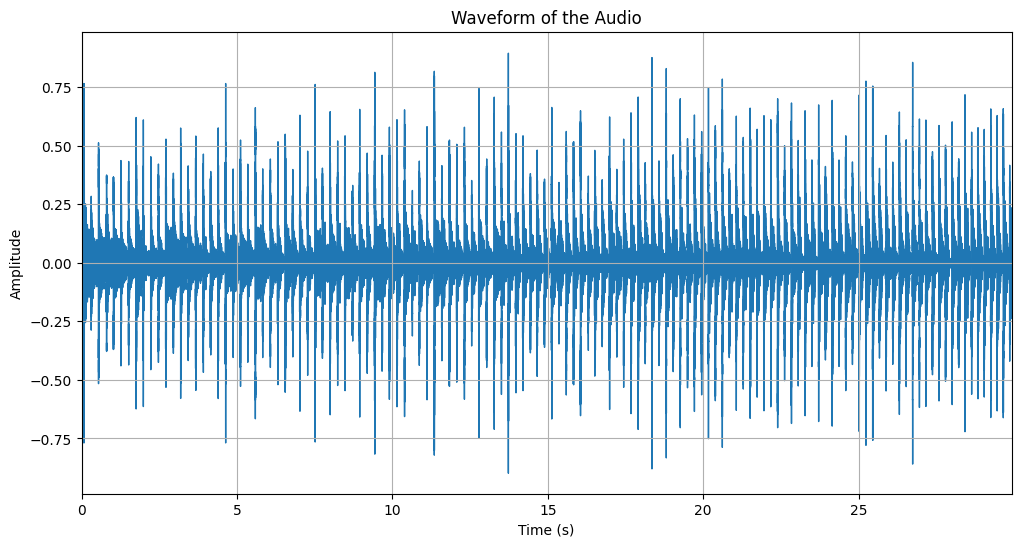

In [3]:
# Pre-process wav & Run OaF inference
to_process = []

# Assuming audio_wav is a bytes object or a BytesIO file-like object
audio_bytes = io.BytesIO(audio_wav)
sampling_rate, audio_values = scipy.io.wavfile.read(audio_bytes)

print('Got WAV audio (channels: {channels}) with length {length} bytes ({duration:.2f}s)'.format(channels=audio_values.ndim, length=audio_values.shape[0], duration=len(audio_values)/sampling_rate))

example_list = list(
  audio_label_data_utils.process_record(
      wav_data=audio_wav,
      sample_rate=hparams.sample_rate,
      ns=note_seq.NoteSequence(),
      example_id="audio-example",
      min_length=0,
      
      max_length=-1,
      allow_empty_notesequence=True))
assert len(example_list) == 1
to_process.append(example_list[0].SerializeToString())
  
sess = tf.Session()

sess.run([
    tf.initializers.global_variables(),
    tf.initializers.local_variables()
])

sess.run(iterator.initializer, {examples: to_process})

def transcription_data(params):
  del params
  return tf.data.Dataset.from_tensors(sess.run(next_record))
input_fn = infer_util.labels_to_features_wrapper(transcription_data)

# Run OaF inference
tf.get_logger().setLevel('ERROR') # hides all INFO messages

prediction_list = list(
    estimator.predict(
        input_fn,
        yield_single_examples=False))
assert len(prediction_list) == 1

sequence_prediction = note_seq.NoteSequence.FromString(
    prediction_list[0]['sequence_predictions'][0])

# Ignore warnings caused by pyfluidsynth
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Plotting

# Convert audio data to floating-point format
if audio_values.dtype == np.int16:
    audio_values_normalized = audio_values.astype(np.float32) / 32768.0  # Normalize for int16
elif audio_values.dtype == np.int32:
    audio_values_normalized = audio_values.astype(np.float32) / 2147483648.0  # Normalize for int32
elif audio_values.dtype == np.uint8:
    audio_values_normalized = (audio_values.astype(np.float32) - 128) / 128.0  # Normalize for uint8

plt.figure(figsize=(12, 6))
librosa.display.waveplot(audio_values_normalized, sr=sampling_rate)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Waveform of the Audio")
plt.grid()

# Plot MIDI
note_seq.plot_sequence(sequence_prediction)

# Plot waveform
plt.show()

# Play MIDI
note_seq.play_sequence(sequence_prediction, note_seq.midi_synth.fluidsynth,
                 colab_ephemeral=False)

In [15]:
# Save MIDI
midi_filename = ('prediction.mid')
midi_io.sequence_proto_to_midi_file(sequence_prediction, midi_filename)